# 0. Install and Import dependencies

In [1]:
!pip install tensorflow stable-baselines3[extra] gymnasium

In [2]:
import gymnasium as gym
from gymnasium import spaces

# Stable Baselines3
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO

# Processing libraries
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 1. Load BTCUSD Data 
https://www.coingecko.com/it/monete/bitcoin/historical_data?start=2025-01-01&end=2025-05-26
https://www.marketwatch.com/investing/cryptocurrency/btcusd/download-data?mod=mw_quote_t


In [3]:
# Load DataFrame
df_processed = pd.read_csv('data/BTCUSD_processed.csv')

print("First rows of the dataframe:")
print(df_processed.head(15))

First rows of the dataframe:
          date   open   high    low  close        volume           sma  \
0   2022-12-18  16706  16798  16669  16760  1.508638e+10  17151.083333   
1   2022-12-19  16760  16832  16531  16595  1.113405e+10  17131.833333   
2   2022-12-20  16595  17046  16288  16862  1.771967e+10  17103.833333   
3   2022-12-21  16861  16924  16738  16780  2.493822e+10  17077.083333   
4   2022-12-22  16780  16863  16566  16781  1.606277e+10  17044.416667   
5   2022-12-23  16780  16917  16764  16804  1.784783e+10  17019.333333   
6   2022-12-24  16804  16854  16763  16842  1.676539e+10  16996.083333   
7   2022-12-25  16842  16851  16734  16768  1.016985e+10  16914.083333   
8   2022-12-26  16768  16912  16766  16839  1.257445e+10  16836.083333   
9   2022-12-27  16839  16962  16601  16655  1.257500e+10  16772.416667   
10  2022-12-28  16655  16772  16560  16589  1.743606e+10  16748.416667   
11  2022-12-29  16588  16650  16468  16596  1.911361e+10  16739.250000   
12  2022-

# 2. Build Environment


--- Index 29 ---
open (norm): [-0.00322196  0.         -0.00984487] ... [0.16193317 0.24576372 0.24749403]
high (norm): [0.0022673  0.00429594 0.01706444] ... [0.26712412 0.25692123 0.2786396 ]
low (norm): [-0.00542959 -0.01366348 -0.02816229] ... [0.15692124 0.2276253  0.23108593]
close (norm): [ 0.         -0.00984487  0.00608592] ... [0.24576372 0.24749403 0.2699284 ]
sma (norm): [0.02333433 0.02218576 0.02051512] ... [0.05792065 0.07905231 0.10133751]
volume (log+scaled): [0.6281254  0.5753871  0.65605545] ... [0.79528457 0.8343944  0.70187837]
rsi (/100): [0.4394132  0.41757977 0.463992  ] ... [0.90512174 0.9057841  0.9141514 ]

Long-Term Features:
  distance_from_sma_200 (scaled): -0.4912
  volatility_100 (scaled): 0.7263
  position_in_200_range (scaled): -0.4851


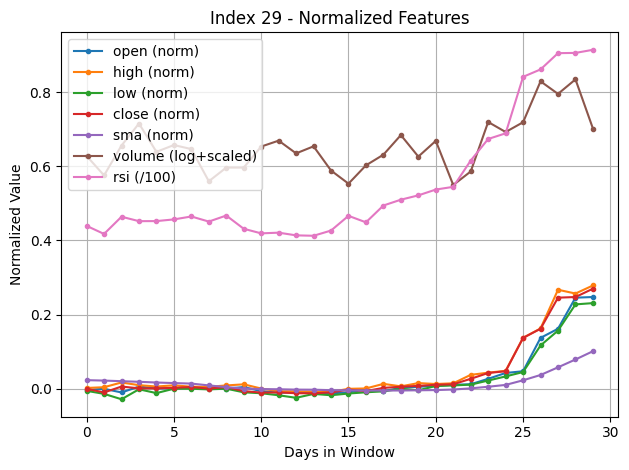


--- Index 79 ---
open (norm): [-0.00517211  0.          0.00873609] ... [-0.03298853 -0.02590403 -0.02855529]
high (norm): [0.00604138 0.01447323 0.01855876] ... [-0.01586405 -0.01808067 -0.01994958]
low (norm): [-0.01577712 -0.01573366 -0.01425591] ... [-0.03637865 -0.03142385 -0.04624479]
close (norm): [ 0.          0.00873609 -0.00730181] ... [-0.02590403 -0.02855529 -0.04133345]
sma (norm): [0.00970677 0.01003999 0.00905482] ... [ 0.00678749  0.00157192 -0.00524455]
volume (log+scaled): [0.7270926  0.76900524 0.7923433 ] ... [0.60744864 0.6391996  0.6865713 ]
rsi (/100): [0.60667515 0.6221558  0.5772391 ] ... [0.4338226  0.42845315 0.40258995]

Long-Term Features:
  distance_from_sma_200 (scaled): -0.3470
  volatility_100 (scaled): -0.9918
  position_in_200_range (scaled): -0.2377


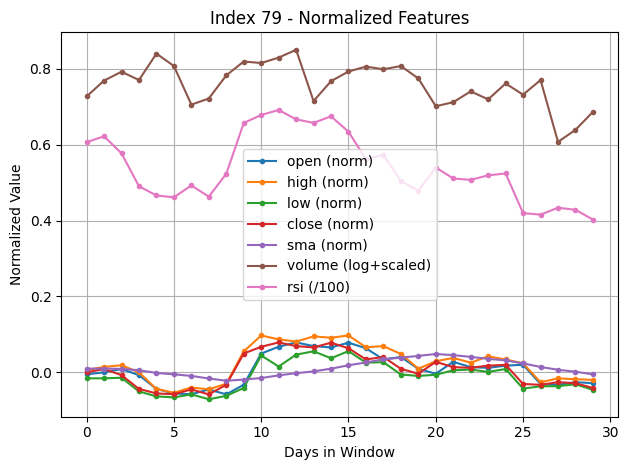


--- Index 129 ---
open (norm): [-1.6769961e-02  7.2912866e-05  3.5909589e-02] ... [ 0.00174991 -0.00178637  0.00699964]
high (norm): [0.00262486 0.04385709 0.06354357] ... [0.02048852 0.01206708 0.09398469]
low (norm): [-0.02774335 -0.01086402  0.01093693] ... [-0.01567627 -0.00816624  0.00699964]
close (norm): [0.         0.03561794 0.02016041] ... [-0.00182282  0.00703609  0.01753554]
sma (norm): [0.00622494 0.01084579 0.01254101] ... [0.05793231 0.04960809 0.04220744]
volume (log+scaled): [0.66371566 0.6554551  0.6863466 ] ... [0.58002704 0.6430751  0.6494876 ]
rsi (/100): [0.5896048  0.62647027 0.6012289 ] ... [0.4308591  0.45152834 0.4758253 ]

Long-Term Features:
  distance_from_sma_200 (scaled): 0.5332
  volatility_100 (scaled): 1.1762
  position_in_200_range (scaled): 0.3657


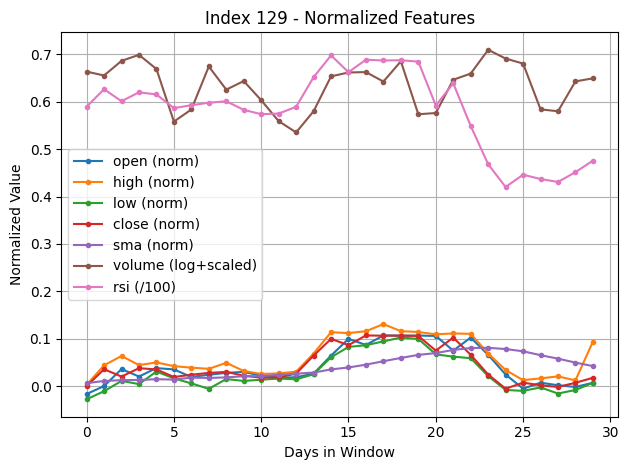

In [4]:
# This function creates a normalized observation vector for the agent at a given timestep
def get_normalized_observation(df_processed, # your full DataFrame (with engineered features)
                               current_idx, # the current timestep index
                               window_size, # how many past days to include in the observation
                               volume_scaler, # scaler fit on log(volume)
                               long_term_feature_scalers): # dictionary of scalers for long-term features
    start_idx = current_idx - window_size + 1 # compute the starting index of the sliding window
    if start_idx < 0:
        raise IndexError("Not enough data for the observation window.")
        
    window_df = df_processed.iloc[start_idx : current_idx + 1] # slice of the df that represents the window of past data

    price_cols = ['open', 'high', 'low', 'close', 'sma'] # price-related features to be normalized
    first_close = window_df['close'].iloc[0]
    
    # Normalize price-like features relative to the first close in the window
    if abs(first_close) < 1e-9: # if it's to close to 0
        price_features = [np.zeros(window_size, dtype=np.float32) for _ in price_cols]
    else: # normalize all prices by dividing by the first close and subtracting 1: makes first value 0 and rest relative
        price_features = [(window_df[col].values / first_close) - 1.0 for col in price_cols]

    # Traded volume of Bitcoin typically has large values and it tends to be very skewed
    # Normalize volume: apply log transform to reduce skew, then scale to [0, 1] for model input
    if 'volume_log' not in window_df.columns:
        window_df = window_df.copy() # changing df from a view to an isolated copy (no link to the original df)
        window_df['volume_log'] = np.log1p(window_df['volume']) # np.log1p(volume) == log(1 + volume)
    normalized_volume = volume_scaler.transform(window_df[['volume_log']]).flatten() # minmax scaling wrt training data

    # Normalize RSI (0–1 scale)
    normalized_rsi = window_df['rsi'].values / 100.0 # RSI is already bounded between 0–100, so dividing by 100 puts it on a 0–1 scale

    # Normalize long-term features from the current day using pre-fit scalers (mean=0, std=1)
    current_features = df_processed.iloc[current_idx]
    normalized_long_term = [
        scaler.transform(pd.DataFrame({name: [current_features[name]]}))[0, 0]
        for name, scaler in long_term_feature_scalers.items()
    ] # The result is a list of normalized long-term feature values, e.g.: normalized_long_term = [0.42, -0.18, 1.25]

    # Combine all into one observation vector
    observation = np.concatenate([
        np.concatenate(price_features),
        normalized_volume,
        normalized_rsi,
        np.array(normalized_long_term)
    ])
    return observation.astype(np.float32)

# Plots and prints values from a single observation vector
def inspect_single_observation(obs_vector, window_size,
                               window_names, # list of labels for windowed features
                               long_term_names, desc="Sample",
                               n=3): # how many values to show from start/end
    total_window_elements = len(window_names) * window_size
    window_part = obs_vector[:total_window_elements] # windowed time-series features
    long_term_part = obs_vector[total_window_elements:] # static daily features

    print(f"\n--- {desc} ---")
    # Loop over each windowed feature, extract its values, print the first/last few (n) values, and plot them
    for i, name in enumerate(window_names):
        vals = window_part[i * window_size : (i + 1) * window_size]
        print(f"{name}: {vals[:n]} ... {vals[-n:]}")
        plt.plot(vals, label=name, marker='.', linestyle='-')

    if long_term_names: # if there are long-term features, print each one’s value
        print("\nLong-Term Features:")
        for name, val in zip(long_term_names, long_term_part):
            print(f"  {name}: {val:.4f}")

    plt.title(f"{desc} - Normalized Features")
    plt.xlabel("Days in Window")
    plt.ylabel("Normalized Value")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Add volume_log column ---
df_processed['volume_log'] = np.log1p(df_processed['volume'])

# --- Fit scalers on training data only ---
train_split_idx = int(len(df_processed) * 0.8)
train_df = df_processed.iloc[:train_split_idx].copy()

# volume_scaler learns min and max values from the training data only and then uses that to scale future data consistently
volume_scaler = MinMaxScaler().fit(train_df[['volume_log']])

lt_features = ['distance_from_sma_200', 'volatility_100', 'position_in_200_range']
long_term_feature_scalers = {
    feat: StandardScaler().fit(train_df[[feat]]) for feat in lt_features
}

# --- Feature/Plot Labels ---
WINDOW_SIZE = 30
window_names = [
    'open (norm)', 'high (norm)', 'low (norm)', 'close (norm)', 'sma (norm)',
    'volume (log+scaled)', 'rsi (/100)'
]
long_term_names = [f'{f} (scaled)' for f in lt_features]

# --- Inspect a few sample observations ---
# Inspects 3 sample observations from the dataset at increasing intervals (every 50 days),
# to visually verify that features are scaled and encoded correctly
for i in range(min(3, len(df_processed) - WINDOW_SIZE + 1)):
    current_idx = WINDOW_SIZE - 1 + i * 50
    obs = get_normalized_observation(
        df_processed, current_idx, WINDOW_SIZE, volume_scaler, long_term_feature_scalers
    )
    inspect_single_observation(obs, WINDOW_SIZE, window_names, long_term_names, desc=f"Index {current_idx}")

## 2.2 Create New Environments

In [5]:
class BitcoinTradingEnv(gym.Env): # OpenAI Gym enviroment
    metadata = {'render_modes': ['human'], 'render_fps': 30}

    # Constructor
    def __init__(self,
                 df, # dataframe with historical data (price, volume, etc.)
                 window_size, # how many days of historical data to use in the observation
                 initial_balance, # starting USD amount
                 volume_scaler, long_term_feature_scalers, # normalization tools
                 transaction_cost_pct=0.0):  # transaction fee (not used here)
        
        super().__init__() # initializes the parent gym.Env class

        # Store inputs as instance variables
        self.df = df
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.volume_scaler = volume_scaler
        self.long_term_feature_scalers = long_term_feature_scalers
        self.transaction_cost_pct = transaction_cost_pct

        # Parameters for the environment logic
        self.holding_penalty_pct = 0.001 # penalty for holding during volatility
        self.action_reward = 0.1  # bonus for any trade

        # Define action and observation spaces
        self.action_space = spaces.Discrete(2) # buy, sell
        self.obs_vector_length = (5 * window_size) + window_size + window_size + len(long_term_feature_scalers)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.obs_vector_length,), dtype=np.float32
        ) # an array (1D vector of floats with no bounds) containing the 30 days window with all 7 features + the 2 long term features

        # Initialize the environment state
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window_size - 1 # start after window_size to ensure a full historical window is available
        self.balance = self.initial_balance # starting with initial_balance USD
        self.btc_held = 0.0 # starting with 0 BTC
        self.net_worth = self.initial_balance
        self.max_steps = len(self.df) - 1 # agent goes through all the dataset (training or testing)
        self.prev_price = self._get_current_price()
        self.buy_price = None
        self.short_price = None  # price at which short was initiated
        self.btc_shorted = 0.0   # how much BTC was shorted
        return self._get_observation(), self._get_info()

    def _get_current_price(self): # returns the current closing price
        return self.df['close'].iloc[self.current_step]

    # Builds the state from historical and long-term features
    def _get_observation(self):
        return get_normalized_observation( # call the function to get and normalize the previous 30 days
            self.df, self.current_step, self.window_size,
            self.volume_scaler, self.long_term_feature_scalers
        )

    # Returns details about the environment’s current state for logging/debugging
    def _get_info(self):
        return {
            "step": self.current_step,
            "balance": self.balance,
            "btc_held": self.btc_held,
            "net_worth": self.net_worth,
            "current_price": self._get_current_price(),
            "btc_shorted": self.btc_shorted,
            "short_price": self.short_price
        }

    # Executes one step in the environment based on the action taken
    def step(self, action):
        prev_net_worth = self.net_worth
        current_price = self._get_current_price()
        reward = 0.0

        # Penalty for holding in volatile conditions (missing opportunities or not avoiding losses)
        price_change = abs(current_price - self.prev_price) / self.prev_price if self.prev_price > 0 else 0 # relative price change
        high_volatility = price_change > 0.001 # volatile market if the price changed 0,5% w.r.t. the previous day

        # --- ACTION EXECUTION ---
        # Buy: opens a long position if holding cash or closes a short
        # Sell: opens a short if not holding BTC or closes a long
        # Hold: does nothing
        # Now we allow short-selling: you can sell BTC even if you don't own it (go short)
        
        # Buy
        if action == 0:
            # If currently shorting, close short position
            if self.btc_shorted > 0:
                cost_to_cover = self.btc_shorted * current_price # buying the "borrowed" btc at current price
                short_profit = (self.short_price - current_price) * self.btc_shorted  # profit if price dropped
                self.balance -= cost_to_cover
                self.balance += self.short_price * self.btc_shorted  # add back what we "sold" at start of the short position

                # Calculating the profit relative to the dimension of the short position
                profit_pct = short_profit / (self.short_price * self.btc_shorted) if self.short_price > 0 else 0
                reward += profit_pct * 100 # amplify profit or loss reward
                reward += self.action_reward
        
                self.btc_shorted = 0.0
                self.short_price = None
        
            # Otherwise, go long if not already holding BTC
            elif self.balance > 0:
                amount = self.balance
                btc_bought = amount / current_price if current_price > 0 else 0
                self.btc_held += btc_bought
                self.balance = 0
                self.buy_price = current_price # stores buy_price for profit calculation on sell
                reward += self.action_reward # adds a small reward for making a trade

            elif high_volatility: # applies a small penalty for holding BTC during volatile price changes
                reward -= self.holding_penalty_pct * self.initial_balance
        
        # Sell
        elif action == 1:
            # If holding BTC, sell and close long position
            if self.btc_held > 0: # Sells all the BTC at the current price
                sell_value = self.btc_held * current_price
                self.balance += sell_value
                self.btc_held = 0
        
                if self.buy_price: # if buy_price is set, calculates profit % and add reward
                    profit_pct = (current_price - self.buy_price) / self.buy_price
                    reward += profit_pct * 100 # amplify profit or loss reward
                reward += self.action_reward # adding the small reward for taking an action (a trade)
                self.buy_price = None # because the trade (long) is concluded
        
            # Otherwise, open short position if not already shorting
            elif self.btc_shorted == 0:
                # short entire balance worth of BTC
                btc_shorted = (self.balance / 2) / current_price if current_price > 0 else 0 # shorting half of the balance
                self.btc_shorted = btc_shorted
                self.short_price = current_price
                reward += self.action_reward # adding the small reward for opening a position

            elif high_volatility:   # penalize holding short during volatile price changes
                reward -= self.holding_penalty_pct * self.initial_balance

        # Update net worth
        short_liability = self.btc_shorted * current_price # if shorting, we assume borrowed BTC must be bought back later (liability)
        self.net_worth = self.balance + self.btc_held * current_price - short_liability

        # Give a reward for an every step feedback and to encourage the agent to exit losing positions
        # reward += (self.net_worth - prev_net_worth) * 0.01  # small net worth delta
        reward += (self.net_worth - prev_net_worth) / self.initial_balance * 100  # = % gain
        # So every step gives a small reward: e.g. +0.5 for 0.5% net worth increase or -1.0 for 1% drop

        self.prev_price = current_price
        self.current_step += 1 # move to the next time step

        # Ends episode if: reached end of dataset or the net worth falls below 10% of initial balance
        terminated = self.current_step >= self.max_steps or self.net_worth <= self.initial_balance * 0.1
        truncated = False

        # In Gym environments, the step() function must always return an observation, even if the episode has ended 
        observation = (
            self._get_observation() if not terminated
            else np.zeros(self.observation_space.shape, dtype=np.float32) # if episode is over, return a dummy observation
        )

        if terminated:
            info = self._get_info()
            info["episode"] = {
                "r": float(self.net_worth - self.initial_balance),  # or sum of rewards if you track them
                "l": self.current_step
            }
        else:
            info = self._get_info()

        return observation, reward, terminated, truncated, self._get_info()

    # Print summary of the current portfolio status
    def render(self):
        print(f"Step: {self.current_step} | Net Worth: ${self.net_worth:.2f} | BTC Held: {self.btc_held:.6f} | Shorted: {self.btc_shorted:.6f} | Balance: ${self.balance:.2f}")

# 3. Training

In [6]:
from stable_baselines3.common.callbacks import BaseCallback

class RewardNetWorthLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.episode_net_worths = []

    def _on_step(self) -> bool:
        # We can use `infos` to extract custom environment info
        for info in self.locals.get("infos", []):
            if "episode" in info:
                reward = info["episode"]["r"]
                length = info["episode"]["l"]
                self.episode_rewards.append(reward)
                if "net_worth" in info:
                    self.episode_net_worths.append(info["net_worth"])
                if self.verbose:
                    print(f"Episode finished: reward={reward:.2f}, length={length}")
        return True

In [7]:
from stable_baselines3.common.callbacks import BaseCallback

class EpisodeRewardLogger(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        # Check if an episode finished
        for info in self.locals.get("infos", []):
            if "episode" in info:
                ep_reward = info["episode"]["r"]
                ep_len = info["episode"]["l"]
                print(f"Episode done: reward={ep_reward:.2f}, length={ep_len}")
        return True


In [8]:
# Parameters
WINDOW_SIZE = 30
INITIAL_BALANCE = 10000
TRANSACTION_COST = 0 #0.001  # example value

# Split dataset
train_ratio = 0.8
split_idx = int(len(df_processed) * train_ratio)

df_train = df_processed.iloc[:split_idx].reset_index(drop=True)
df_test = df_processed.iloc[split_idx:].reset_index(drop=True)

# Arguments for the environment constructor
train_env_args = dict(
    df=df_train,
    window_size=WINDOW_SIZE,
    initial_balance=INITIAL_BALANCE,
    volume_scaler=volume_scaler,
    long_term_feature_scalers=long_term_feature_scalers,
    transaction_cost_pct=TRANSACTION_COST
)

test_env_args = dict(
    df=df_test,
    window_size=WINDOW_SIZE,
    initial_balance=INITIAL_BALANCE,
    volume_scaler=volume_scaler,
    long_term_feature_scalers=long_term_feature_scalers,
    transaction_cost_pct=TRANSACTION_COST
)

def make_train_env():
    return BitcoinTradingEnv(**train_env_args)

def make_test_env():
    return BitcoinTradingEnv(**test_env_args)

# Vectorized Envs
train_vec_env = DummyVecEnv([make_train_env])
test_vec_env = DummyVecEnv([make_test_env])

In [9]:
def faster_schedule(initial_value: float, power: float = 2.0, min_lr: float = 0.0):
    """
    Learning rate schedule that decreases based on a power of progress_remaining.
    A higher power makes the learning rate decrease faster.
    It can also ensure the learning rate does not drop below min_lr.

    :param initial_value: Initial learning rate.
    :param power: The power to which progress_remaining is raised (e.g., 2.0 for quadratic decay).
                  Must be >= 1.0. Higher values mean faster decay.
    :param min_lr: The minimum learning rate. The schedule will not go below this value.
    :return: schedule that computes
      current learning rate depending on remaining progress.
    """
    if power < 1.0:
        raise ValueError("Power must be >= 1.0 for the learning rate to decrease or stay linear.")

    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.
        :param progress_remaining: (fraction of training remaining)
        :return: current learning rate
        """
        # progress_remaining va da 1.0 a 0.0
        # (progress_remaining ** power) farà sì che il moltiplicatore scenda più velocemente se power > 1
        decayed_value = (progress_remaining ** power) * initial_value
        
        # Assicura che il learning rate non scenda sotto min_lr
        # e non superi initial_value (anche se con power >=1 e progress_remaining <=1 non dovrebbe succedere)
        current_lr = np.clip(decayed_value, min_lr, initial_value)
        
        return current_lr
    return func

In [10]:
# Define training parameters
#n_steps_value = 2048
#minibatch_size = 256
#ent_coef_value = 0.001
#vf_coef_value = 0.8
#gae_lambda_value = 0.95
initial_learning_rate = 0.001
decay_power = 2.0 # For a quadratic decay (faster than linear)
minimum_learning_rate = 1e-6 # A small minimum learning

# Optional: Tensorboard log path
tensorboard_log_dir = "./ppo_bitcoin_tensorboard/"

# Optional: Custom policy network architecture
policy_kwargs = dict(net_arch=dict(pi=[64, 64], vf=[128, 128]))

# Model initialization
model = PPO(
    "MlpPolicy",
    train_vec_env,
    verbose=1,
    #n_steps=n_steps_value,
    #batch_size=minibatch_size,
    #ent_coef=ent_coef_value,
    #vf_coef=vf_coef_value,
    #gae_lambda=gae_lambda_value,
    learning_rate=faster_schedule(initial_learning_rate, power=decay_power, min_lr=minimum_learning_rate),
    policy_kwargs=policy_kwargs,
    tensorboard_log=tensorboard_log_dir
)

Using cpu device


In [11]:
# Training
reward_logger = RewardNetWorthLoggerCallback(verbose=1)

TOTAL_TIMESTEPS = 3000000
print(f"Starting PPO training for {TOTAL_TIMESTEPS} timesteps...")
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=EpisodeRewardLogger())
model.save("ppo_bitcoin_trader_3M_short")

Starting PPO training for 3000000 timesteps...
Logging to ./ppo_bitcoin_tensorboard/PPO_7
-----------------------------
| time/              |      |
|    fps             | 272  |
|    iterations      | 1    |
|    time_elapsed    | 7    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 260         |
|    iterations           | 2           |
|    time_elapsed         | 15          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007098282 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.681      |
|    explained_variance   | 0.00114     |
|    learning_rate        | 0.000999    |
|    loss                 | 420         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00157    |
|    value_loss           | 

# 4. Testing

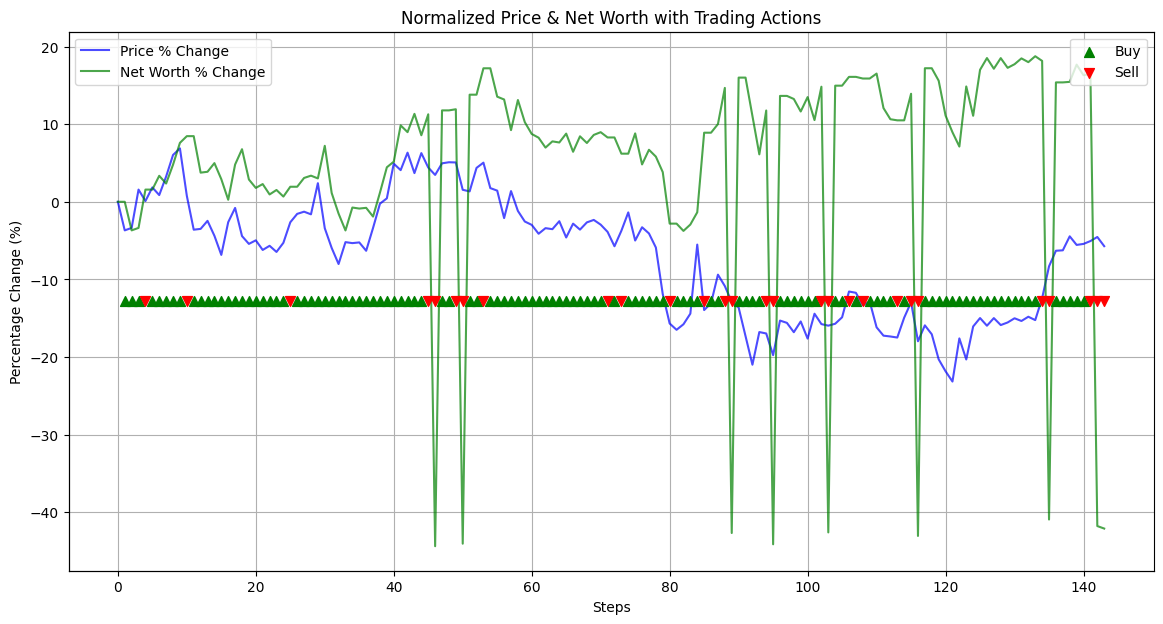

In [12]:
test_env = BitcoinTradingEnv(**test_env_args)
obs, info = test_env.reset()
done = False

net_worths = [info["net_worth"]]
prices = [info["current_price"]]
actions = []

while not done:
    action, _states = model.predict(obs, deterministic=True)
    action = int(action)  # Convert to int to fix unhashable type error
    obs, reward, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated
    
    net_worths.append(info["net_worth"])
    prices.append(info["current_price"])
    actions.append(action)

actions = [None] + actions  # Align length with prices/net_worths

# Normalize price and net worth to percentage change from first value
price_pct = 100 * (np.array(prices) / prices[0] - 1)
net_worth_pct = 100 * (np.array(net_worths) / net_worths[0] - 1)

fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.plot(price_pct, label='Price % Change', color='blue', alpha=0.7)
ax1.plot(net_worth_pct, label='Net Worth % Change', color='green', alpha=0.7)
ax1.set_xlabel('Steps')
ax1.set_ylabel('Percentage Change (%)')
ax1.legend(loc='upper left')
ax1.grid(True)

ax2 = ax1.twinx()

action_colors = {0: 'green', 1: 'red'}
action_labels = {0: 'Buy', 1: 'Sell'}

# To avoid duplicate legend entries
plotted_labels = set()

for i, act in enumerate(actions):
    if act is not None:
        color = action_colors[act]
        label = action_labels[act] if act not in plotted_labels else None
        marker = '^' if act == 0 else 'v'
        ax2.scatter(i, 0, color=color, label=label, marker=marker, s=50)
        plotted_labels.add(act)

ax2.set_yticks([])
ax2.set_ylim(-1, 1)
ax2.spines['right'].set_visible(False)

ax2.legend(loc='upper right')

plt.title('Normalized Price & Net Worth with Trading Actions')
plt.show()